#1.1. BASIC LIBRARIES AND GIVEN CONTROL SYSTEM  

In [2]:
pip install tensorflow

In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# System matrices
A = np.array([[0, 1, 0, 0],
              [3, 0, 0, 2],
              [0, 0, 0, 1],
              [0, -2, 0, 0]])
B = np.array([[0, 0],
              [1, 0],
              [0, 0],
              [0, 1]])

n = A.shape[0]        # state dimension
m = B.shape[1]
T = 1.0               # final time
N = 100               # number of time points
time_points = np.linspace(0, T, N)


#1.2. DATASET GENERATION

In [4]:
from scipy.integrate import quad_vec
from scipy.linalg import expm

def compute_grammian(A, B, T):
    def integrand(t):
        e_At = expm(A * (T - t))
        return e_At @ B @ B.T @ e_At.T  # returns 2D (n x n) NumPy array

    W, _ = quad_vec(integrand, 0, T)
    return W

# Generate u(t) numerically
def compute_control(A, B, x0, x1, T, time_points):
    W = compute_grammian(A, B, T)
    W_inv = np.linalg.inv(W)
    expAT = expm(A * T)
    diff = x1 - expAT @ x0

    u_vals = []
    for t in time_points:
        e_AtT = expm(A.T * (T - t))
        u_t = B.T @ e_AtT @ W_inv @ diff
        u_vals.append(u_t)
    return np.array(u_vals).T  # shape: (m, N)

# Generate dataset
np.random.seed(42)       # seed for reproducibility
def sample_data_numeric(num_samples=2000):
    X, Y = [], []
    for _ in range(num_samples):
        x0 = np.random.uniform(0, 5, n)
        x1 = np.random.uniform(0, 5, n)
        u_vals = compute_control(A, B, x0, x1, T, time_points)
        X.append(np.concatenate([x0, x1]))   # shape of each input data: (2*n,)
        Y.append(u_vals.flatten())  # shape of each output data: (m * N,)
    return np.array(X), np.array(Y)

# Generate and save
X_data, Y_data = sample_data_numeric(num_samples=2000)
np.savez("controller_dataset.npz", X=X_data, Y=Y_data, time=time_points)
print("Numeric dataset saved as controller_dataset.npz")


Numeric dataset saved as controller_dataset.npz


#1.3. MODEL TRAINING

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

# Load dataset
data = np.load('/content/controller_dataset.npz')
X = data['X']  # shape: (2000, 2*n)
Y = data['Y']  # shape: (2000, m*N)
time_points = data['time']  # shape: (100,)

# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# To Define the Sequential model with L2 regularization
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(8,),
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(200) # 2 control inputs × 100 time steps and no Activation func as its a regression task
])
# Compile
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Train
history = model.fit(X_train, Y_train, epochs=80, batch_size=32,
                    validation_data=(X_val, Y_val), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0766 - loss: 160.3601 - val_accuracy: 0.4475 - val_loss: 83.9704
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4303 - loss: 72.7224 - val_accuracy: 0.5425 - val_loss: 25.9123
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4951 - loss: 14.7073 - val_accuracy: 0.6000 - val_loss: 3.3783
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6334 - loss: 2.6018 - val_accuracy: 0.6225 - val_loss: 1.5722
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6484 - loss: 1.2125 - val_accuracy: 0.6225 - val_loss: 0.7818
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6977 - loss: 0.5689 - val_accuracy: 0.7250 - val_loss: 0.3249
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7327 - loss: 0.2959 - val_accuracy: 0.7375 - val_loss: 0.2319
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7482 - loss: 0.2389 - val_accuracy: 0.7350 - va

In [6]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,810 (1.02 MB)

 Trainable params: 88,936 (347.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 177,874 (694.82 KB)

None


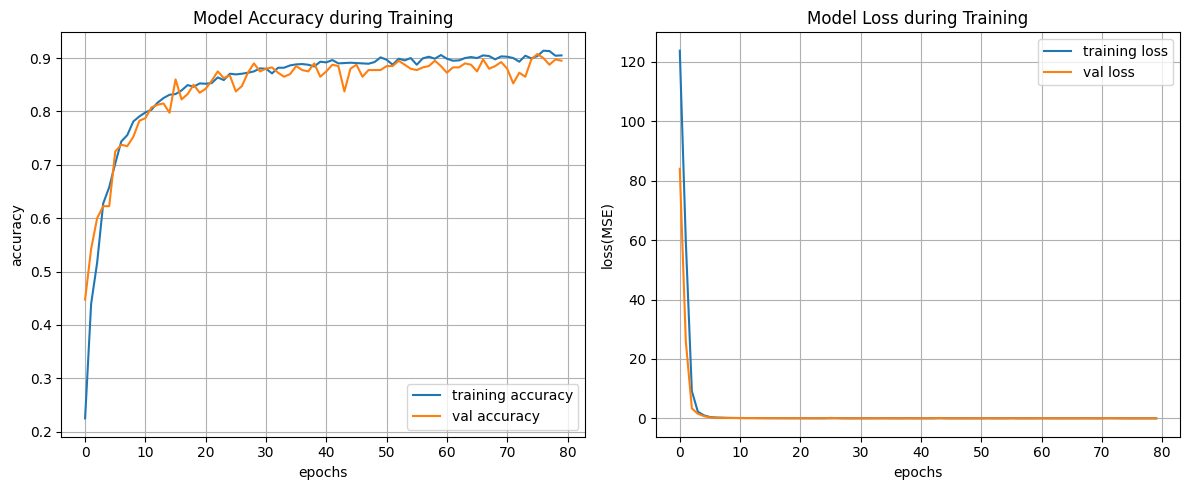

In [7]:
#plotting graphs for accuracy and loss side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(history.history['accuracy'], label='training accuracy')
axes[0].plot(history.history['val_accuracy'], label='val accuracy')
axes[0].set_title('Model Accuracy during Training')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(history.history['loss'], label='training loss')
axes[1].plot(history.history['val_loss'], label='val loss')
axes[1].set_title('Model Loss during Training')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss(MSE)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#1.4. MODEL PREDICTION

In [8]:
# # Predict for new initial and final states
# x0 = np.array([1, 2, 3, 4])
# x1 = np.array([4, 3, 2, 1])
# x_input = np.concatenate([x0, x1]).reshape(1, -1)
# print(x_input)

# u_pred = model.predict(x_input).reshape(2, -1)  # shape: (2, 100)
# print(u_pred)


In [9]:
# Predict for new initial and final states
x0 = np.array([1, 2, 3, 4])
x1 = np.array([0, 0, 0, 0])
x_input = np.concatenate([x0, x1]).reshape(1, -1)
print(x_input)

u_pred = model.predict(x_input).reshape(2, -1)  # shape: (2, 100)
print(u_pred)


[[1 2 3 4 0 0 0 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[[ -6.4951034   -6.70431     -6.853147    -6.9903703   -7.107235
   -7.2832336   -7.4429765   -7.540362    -7.646621    -7.7049046
   -7.8437157   -7.912955    -7.9737916   -8.097335    -8.065921
   -8.129008    -8.181384    -8.146715    -8.093481    -8.173644
   -8.181899    -8.0662565   -8.124964    -8.039331    -8.004427
   -7.9212933   -7.8011904   -7.736074    -7.6835785   -7.5130076
   -7.3584466   -7.2760057   -7.0690737   -6.9554076   -6.781533
   -6.5344977   -6.4304767   -6.227294    -5.9978943   -5.7693715
   -5.6307287   -5.301546    -5.041776    -4.8373995   -4.5274324
   -4.301742    -3.9462917   -3.6823776   -3.3665771   -3.055257
   -2.6848593   -2.3603644   -2.019402    -1.6518558   -1.2834116
   -0.85885113  -0.5375789   -0.06727357   0.2723744    0.7802565
    1.1341811    1.6129555    2.025181     2.5196018    2.9542046
    3.4457533    3.904231     4.4921308    4.896614     5.4938893
    5.990918     6.5137

#1.5. PREDICTED CONTROL INPUTS PLOTTING

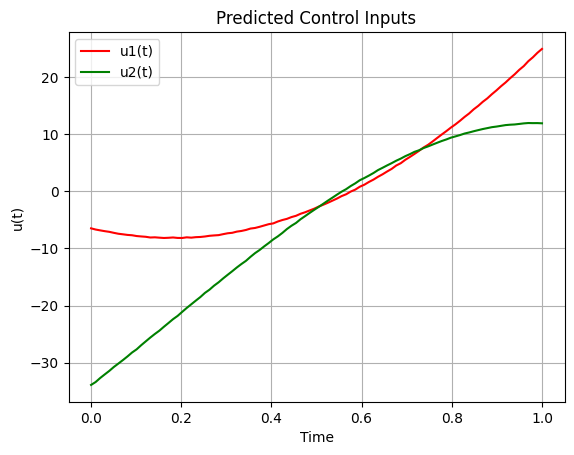

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time_points, u_pred[0], label='u1(t)', color='r')
plt.plot(time_points, u_pred[1], label='u2(t)', color='g')
plt.title("Predicted Control Inputs")
plt.xlabel("Time")
plt.ylabel("u(t)")
plt.legend()
plt.grid(True)
plt.show()


#1.6. SOLUTION OF THE SYSTEM WITH PREDICTED CONTROLS

##1.6.1.Using Simpson's rule

The solution of the system using discrete integration of the formula is:
State at t=1.00: [ 0.16308653  0.32568087  0.05755955 -0.01547149]


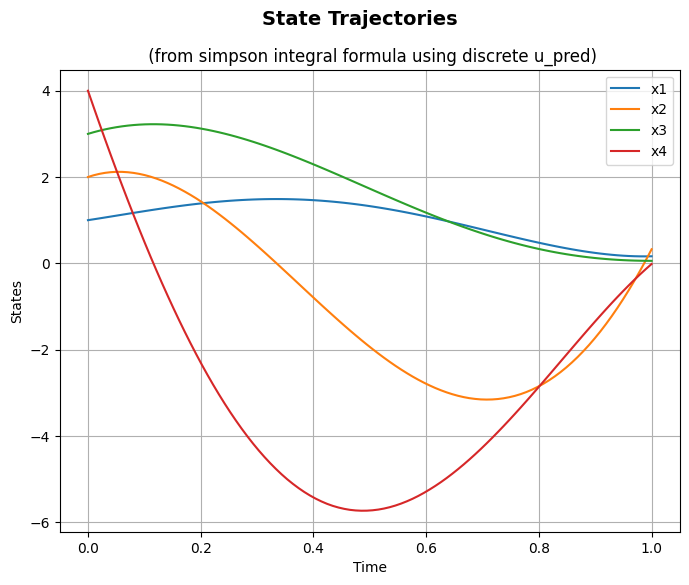

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson # For numerical integration using Simpson's rule

n = A.shape[0] # State dimension
m = B.shape[1]

# Initialize the state trajectory array
x_trajectory_discrete_int = np.zeros((len(time_points), n))

# The initial state is x(0) = x0
x_trajectory_discrete_int[0, :] = x0

# Iterate through the time points to compute x(t) at each point
for i, t in enumerate(time_points):
    if i == 0:
        continue # Already set the initial state

    # Select the time points up to the current time t (inclusive) and the corresponding u_pred values
    time_points_subset = time_points[:i+1]
    u_pred_subset = u_pred[:, :i+1] # u_pred shape is (m, N)

    # Calculate the first part: exp(A*t) * x0
    exp_At = expm(A * t)
    x_part1 = exp_At @ x0

    # Calculate the integrand values at the discrete time points in the subset [0, t]
    # The integrand is F(s) = exp(A*(t-s)) @ B @ u(s)
    # F(s) is a vector of shape (n,)
    integrand_values = np.zeros((n, len(time_points_subset)))

    for k, s in enumerate(time_points_subset):
        exp_A_ts = expm(A * (t - s))
        u_s = u_pred_subset[:, k].reshape(-1, 1) # u at time s, reshaped to column vector
        integrand_values[:, k] = (exp_A_ts @ B @ u_s).flatten()

    # Numerically integrate the integrand values from 0 to t using Simpson's rule
    # Integrate each component of the vector integrand separately
    integral_result = np.zeros(n)
    for j in range(n): # Integrate for each state variable component
        # integrand_values[j, :] contains the values of the j-th component of the integrand at time_points_subset
        integral_result[j] = simpson(integrand_values[j, :], time_points_subset)

    # The state x(t) is the sum of the two parts
    x_trajectory_discrete_int[i, :] = x_part1 + integral_result

print("The solution of the system using discrete integration of the formula is:")
# Print the trajectory at the final time point as an example
print(f"State at t={time_points[-1]:.2f}: {x_trajectory_discrete_int[-1]}")


# Plotting the solution
z = time_points

# x_trajectory_discrete_int has shape (N, n), so I slice columns for each state
xt1 = x_trajectory_discrete_int[:, 0]
xt2 = x_trajectory_discrete_int[:, 1]
xt3 = x_trajectory_discrete_int[:, 2]
xt4 = x_trajectory_discrete_int[:, 3]


plt.figure(figsize=(8, 6))
plt.plot(z, xt1, label='x1')
plt.plot(z, xt2, label='x2')
plt.plot(z, xt3, label='x3')
plt.plot(z, xt4, label='x4')
plt.suptitle("State Trajectories",fontsize=14,fontweight='bold')
plt.title(" (from simpson integral formula using discrete u_pred)")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

##1.6.2.Using Quadrature's Rule

The solution of the system using quad_vec integration is:
State at t=1.00: [ 0.16243058  0.32467161  0.05702653 -0.01568086]


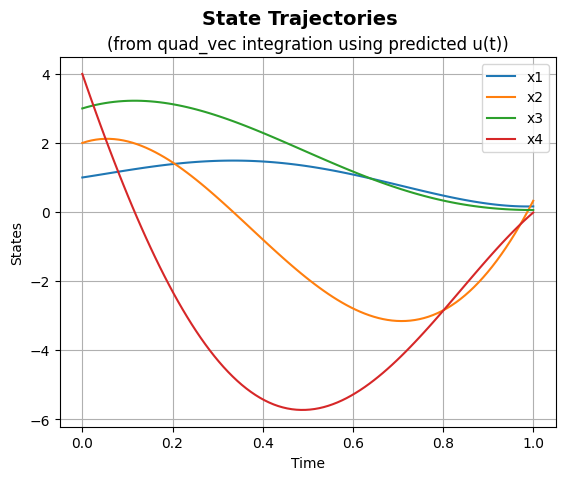

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import quad_vec # For numerical integration of vector functions

# Assuming A, B, T, time_points, x0, u_pred are already defined from previous cells
n = A.shape[0] # State dimension

# Initialize the state trajectory array
x_trajectory_quad_vec = np.zeros((len(time_points), n))

# The initial state is x(0) = x0
x_trajectory_quad_vec[0, :] = x0

# Iterate through the time points to compute x(t) at each point
for i, t in enumerate(time_points):
    if i == 0:
        continue # Already set the initial state

    # Calculate the first part: exp(A*t) * x0
    exp_At = expm(A * t)
    x_part1 = exp_At @ x0

    # Calculate the second part: integral from 0 to t of exp(A*(t-s)) * B * u(s) ds

    # Define the integrand function for quad_vec
    # The integrand should return a vector (or 1D array)
    # The integrand function signature for quad_vec is func(s, *args)
    # Here, the arguments needed are A, B, t, u_pred, time_points

    def integrand_vec_func(s, A, B, current_t, u_pred, time_points):
        # Find the index in time_points closest to s to get u(s)
        idx_s = (np.abs(time_points - s)).argmin()
        u_s = u_pred[:, idx_s].reshape(-1, 1) # Reshape to column vector

        # Calculate the vector integrand: exp(A*(t-s)) @ B @ u(s)
        exp_A_ts = expm(A * (current_t - s))
        integrand_value = exp_A_ts @ B @ u_s

        return integrand_value.flatten() # quad_vec expects a 1D array

    # Perform the integration from 0 to t using quad_vec
    # quad_vec returns the result as a 1D array and an error estimate
    integral_result_vec, _ = quad_vec(integrand_vec_func, 0, t, args=(A, B, t, u_pred, time_points))

    # The state x(t) is the sum of the two parts
    x_trajectory_quad_vec[i, :] = x_part1 + integral_result_vec

print("The solution of the system using quad_vec integration is:")
# Print the trajectory at the final time point as an example
print(f"State at t={time_points[-1]:.2f}: {x_trajectory_quad_vec[-1]}")

# Plotting the solution
z = time_points # Use the time points from the integration results

# x_trajectory_quad_vec has shape (N, n), so we slice columns for each state
xt1_vec = x_trajectory_quad_vec[:, 0]
xt2_vec = x_trajectory_quad_vec[:, 1]
xt3_vec = x_trajectory_quad_vec[:, 2]
xt4_vec = x_trajectory_quad_vec[:, 3]

plt.figure()
plt.plot(z, xt1_vec, label='x1')
plt.plot(z, xt2_vec, label='x2')
plt.plot(z, xt3_vec, label='x3')
plt.plot(z, xt4_vec, label='x4')
plt.suptitle("State Trajectories",fontsize=14,fontweight='bold')
plt.title("(from quad_vec integration using predicted u(t))")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# # Predict for new initial and final states
# x0 = np.array([0,0,0,0])
# x1 = np.array([0, 0, 0, 0])
# x_input = np.concatenate([x0, x1]).reshape(1, -1)
# print(x_input)

# u_pred = model.predict(x_input).reshape(2, -1)  # shape: (2, 100)
# print(u_pred)


In [26]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(time_points, u_pred[0], label='u1(t)', color='r')
# plt.plot(time_points, u_pred[1], label='u2(t)', color='g')
# plt.title("Predicted Control Inputs")
# plt.xlabel("Time")
# plt.ylabel("u(t)")
# plt.legend()
# plt.grid(True)
# plt.show()


In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.linalg import expm # For matrix exponential
# from scipy.integrate import simpson # For numerical integration using Simpson's rule

# n = A.shape[0] # State dimension
# m = B.shape[1]

# # Initialize the state trajectory array
# x_trajectory_discrete_int = np.zeros((len(time_points), n))

# # The initial state is x(0) = x0
# x_trajectory_discrete_int[0, :] = x0

# # Iterate through the time points to compute x(t) at each point
# for i, t in enumerate(time_points):
#     if i == 0:
#         continue # Already set the initial state

#     # Select the time points up to the current time t (inclusive) and the corresponding u_pred values
#     time_points_subset = time_points[:i+1]
#     u_pred_subset = u_pred[:, :i+1] # u_pred shape is (m, N)

#     # Calculate the first part: exp(A*t) * x0
#     exp_At = expm(A * t)
#     x_part1 = exp_At @ x0

#     # Calculate the integrand values at the discrete time points in the subset [0, t]
#     # The integrand is F(s) = exp(A*(t-s)) @ B @ u(s)
#     # F(s) is a vector of shape (n,)
#     integrand_values = np.zeros((n, len(time_points_subset)))

#     for k, s in enumerate(time_points_subset):
#         exp_A_ts = expm(A * (t - s))
#         u_s = u_pred_subset[:, k].reshape(-1, 1) # u at time s, reshaped to column vector
#         integrand_values[:, k] = (exp_A_ts @ B @ u_s).flatten()

#     # Numerically integrate the integrand values from 0 to t using Simpson's rule
#     # Integrate each component of the vector integrand separately
#     integral_result = np.zeros(n)
#     for j in range(n): # Integrate for each state variable component
#         # integrand_values[j, :] contains the values of the j-th component of the integrand at time_points_subset
#         integral_result[j] = simpson(integrand_values[j, :], time_points_subset)

#     # The state x(t) is the sum of the two parts
#     x_trajectory_discrete_int[i, :] = x_part1 + integral_result

# print("The solution of the system using discrete integration of the formula is:")
# # Print the trajectory at the final time point as an example
# print(f"State at t={time_points[-1]:.2f}: {x_trajectory_discrete_int[-1]}")


# # Plotting the solution
# z = time_points

# # x_trajectory_discrete_int has shape (N, n), so I slice columns for each state
# xt1 = x_trajectory_discrete_int[:, 0]
# xt2 = x_trajectory_discrete_int[:, 1]
# xt3 = x_trajectory_discrete_int[:, 2]
# xt4 = x_trajectory_discrete_int[:, 3]


# plt.figure(figsize=(10, 6))
# plt.plot(z, xt1, label='x1')
# plt.plot(z, xt2, label='x2')
# plt.plot(z, xt3, label='x3')
# plt.plot(z, xt4, label='x4')
# plt.suptitle("State Trajectories",fontsize=14,fontweight='bold')
# plt.title(" (from simpson integral formula using discrete u_pred)")
# plt.xlabel("Time")
# plt.ylabel("States")
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
model.save('my_trained_model.keras')

print("Model saved as my_trained_model.keras")

Model saved as my_trained_model.keras


In [24]:
# To load the saved model
loaded_model = tf.keras.models.load_model('my_trained_model.keras')
print("Model loaded successfully.")

Model loaded successfully.
